## Simulated data

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
from datetime import datetime
import pymc3 as pm

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
growth1 = 1.06
growth2 = 1.02
growth3 = 1.005
changepoint1 = 45
changepoint2 = 95

x = np.array(range(151))
y1 = np.exp(x[:changepoint1] * np.log(growth1))

factor1 = np.exp(x[changepoint1] * (np.log(growth1) - np.log(growth2))) 
y2 = factor1 * np.exp(x[changepoint1:changepoint2] * np.log(growth2))

factor2 = np.exp(x[changepoint1] * (np.log(growth1) - np.log(growth2))) \
        * np.exp(x[changepoint2] * (np.log(growth2) - np.log(growth3))) 
y3 = factor2 * np.exp(x[changepoint2:] * np.log(growth3))

y = np.concatenate([y1, y2, y3])

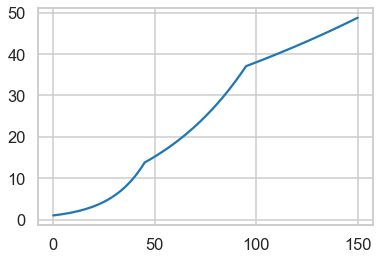

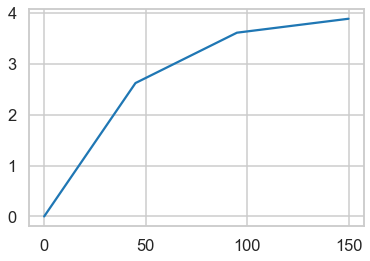

In [6]:
y = pd.Series(y)
plt.plot(y)
plt.show()
plt.plot(np.log(y))

In [16]:
# see https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/

import theano
import theano.tensor as tt

def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)


def fourier_series(x, repeat=7, n_freqs=3):
    ''' creates the sin and cosine curves as numpy arrays
    over the full length of x.
    '''
    fourier = 2 * np.pi * np.arange(1, n_freqs + 1) / repeat
    fourier = fourier * x[:, None]
    fourier = np.concatenate((np.cos(fourier), np.sin(fourier)), axis=1)
    return fourier


# rescale input data
df = pd.DataFrame({'x': x, 'log_y': np.log(y), 'y':y})
x_span = (df['x'].max() - df['x'].min())
df['x_scaled'] = (df['x'] - df['x'].min()) / x_span

n_changepoints = 10
s = np.linspace(0, df['x_scaled'].max(), n_changepoints + 1)[1:]
A = (df['x_scaled'].values[:, None] >= s).astype(int)


with pm.Model() as model:
    # initial growth
    beta_zero_mu = pm.Normal('beta_zero_mu', 0, 10)
    beta_zero = pm.Normal('beta_zero', beta_zero_mu, 2)
    
    beta_prior = pm.Exponential('beta_prior', 0.05)
    beta = pm.Laplace('beta', 0, beta_prior, shape=n_changepoints)

    gamma = -s * beta      
    trend = pm.Deterministic('trend', (beta_zero + det_dot(A, beta)) * df['x_scaled'] + (det_dot(A, gamma)))
    
    
    
    # rescale the period, as t is also scaled
    n_frequencies = 3
    repeat = 7 / (df['x'].max() - df['x'].min())
    fourier_curves = fourier_series(df['x_scaled'], repeat, n_frequencies)
    weekly_fourier_coeff = pm.Normal('weekly_fourier_coeff', mu=0, sd=10, shape=2 * n_frequencies)
    
    weekly = pm.Deterministic('weekly', det_dot(fourier_curves, weekly_fourier_coeff))
    
    obs_sigma = pm.HalfNormal('obs_b', 3)
    pm.Normal('obs', 
               mu=trend + weekly,
               sigma=obs_sigma,
               observed=df['log_y'])

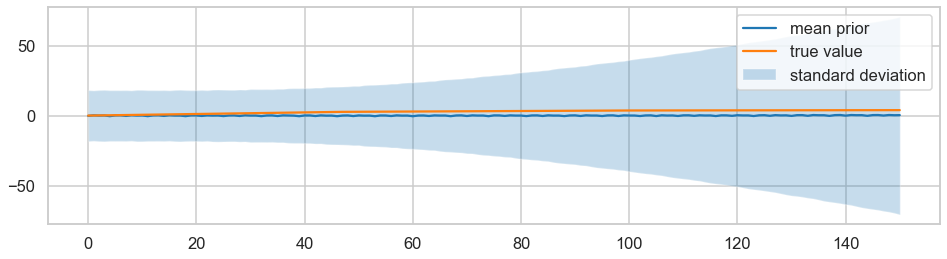

In [17]:
def sanity_check(m, log_y):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=10000, model=m, vars=['obs'])['obs']
    plt.figure(figsize=(16, 4))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(log_y, label='true value')
    plt.legend()

# And run the sanity check
sanity_check(model, np.log(y))

In [ ]:
with model:
    trace = pm.sample(1000, tune=1000)
    posterior = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_b, weekly_fourier_coeff, beta, beta_prior, beta_zero, beta_zero_mu, start_cases]
Sampling 4 chains, 0 divergences:  42%|████▏     | 3366/8000 [01:05<01:39, 46.43draws/s]

In [ ]:
_ = pm.traceplot(trace)

In [ ]:
plot_with_q = pd.DataFrame(trace['trend']).apply(pd.Series.quantile, q=[0.01, 0.5, 0.99]).T
plot_with_q[0.5].plot(figsize=(8,5))
plt.fill_between(plot_with_q.index, plot_with_q[0.01], plot_with_q[0.99], alpha=0.1)
plt.plot(df_ger['Log New Cases'])

In [ ]:
trace['trend'].mean(axis=0)

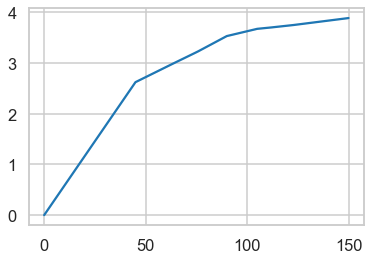

In [14]:
plot_with_q = pd.DataFrame(posterior['obs']).apply(pd.Series.quantile, q=[0.2, 0.5, 0.8]).T
plot_with_q[0.5].plot()
plt.fill_between(plot_with_q.index, plot_with_q[0.2], plot_with_q[0.8], alpha=0.1)

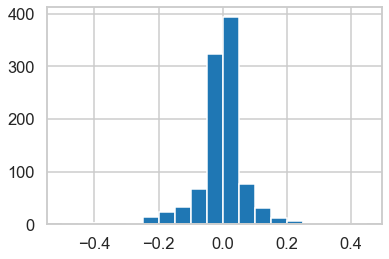

In [15]:
with pm.Model():
    changepoints_prior_scale = pm.Exponential('beta_prior', 20)
    beta = pm.Laplace('beta', 0, changepoints_prior_scale, shape=n_changepoints)
    sample = beta.random(size=1000)
    pd.Series(sample[:, 0]).hist(bins=np.arange(-.5, .5, 0.05))